In [1]:
%cd ~/bioinfo1/project/binfo1-work/

/rna/hyemin/bioinfo1/project/binfo1-work


##### Base positions with cut-offs of 0.8 for crosslinking-induced reverse-transcription error score (CRES) and 50 for read depth.

In [2]:
!samtools mpileup --ff 3860 CLIP-35L33G.bam | \
    awk '$4 >= 50 {print $0}'> motif/CLIP-35L33G-ge50-plus.pileup
!wc -l motif/CLIP-35L33G-ge50-plus.pileup # filter out QC failed, unmapped, secondary, supplementary, and duplicate reads # plus strand

[mpileup] 1 samples in 1 input files
11450468 motif/CLIP-35L33G-ge50-plus.pileup


In [3]:
!samtools mpileup --ff 3844 --rf 16 CLIP-35L33G.bam | \
    awk '$4 >= 50 {print $0}'> motif/CLIP-35L33G-ge50-minus.pileup
!wc -l motif/CLIP-35L33G-ge50-minus.pileup # filter out QC failed, unmapped, secondary, supplementary, and duplicate reads # minus strand

[mpileup] 1 samples in 1 input files
13051391 motif/CLIP-35L33G-ge50-minus.pileup


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

In [9]:
lNames = ['chrom', 'pos', '_ref', 'count', 'basereads', 'quals']
toremove = re.compile('[<>$]|\^.') # [문자들] : 문자들 중 하나와 매치

In [10]:
lFiles = ['motif/CLIP-35L33G-ge50-plus.pileup', 'motif/CLIP-35L33G-ge50-minus.pileup']

In [14]:
for file in lFiles:
    dfPileup = pd.read_csv(file, sep='\t', names=lNames)
    dfPileup['matchesNdel'] = dfPileup['basereads'].apply(lambda x: toremove.sub('', x)) # remove special characters (<>$^.) from basereads
    dfPileup['AGCTD'] = dfPileup['matchesNdel'].apply(lambda x: np.array((x.count('A') + x.count('a'), \
                                                                      x.count('G') + x.count('g'), \
                                                                      x.count('C') + x.count('c'), \
                                                                      x.count('T') + x.count('t'), \
                                                                      x.count('*') + x.count('#'))))
    dfPileup['entropy'] = dfPileup['AGCTD'].apply(lambda x: -sum([i*np.log2(i) for i in x/sum(x) if i > 0])).replace(-0.0, 0.0)
    dfPileup['start'] = dfPileup['pos'] - 1
    dfPileup[dfPileup['entropy'] >= 0.8][['chrom', 'start', 'pos', 'entropy']].to_csv(file[:-len('.pileup')] + '.entropy.BedGraph', sep='\t', index=False, header=False)

##### Neighboring sequences of the high-mutated bases in reference genome (mm39).

In [10]:
!wget -P ~/bioinfo1/project/binfo1-datapack1 https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M35/GRCm39.primary_assembly.genome.fa.gz
!gunzip ~/bioinfo1/project/binfo1-datapack1/GRCm39.primary_assembly.genome.fa.gz

--2024-05-24 23:48:06--  https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M35/GRCm39.primary_assembly.genome.fa.gz
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.193.165
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.193.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 773873008 (738M) [application/x-gzip]
Saving to: ‘/rna/hyemin/bioinfo1/project/binfo1-datapack1/GRCm39.primary_assembly.genome.fa.gz’

GRCm39.primary_asse 100%[===================>] 738.02M   194KB/s    in 60m 44s 

2024-05-25 00:48:51 (207 KB/s) - ‘/rna/hyemin/bioinfo1/project/binfo1-datapack1/GRCm39.primary_assembly.genome.fa.gz’ saved [773873008/773873008]



In [11]:
!rsync -avz ~/bioinfo1/project/binfo1-datapack1/GRCm39.primary_assembly.genome.fa ./

sending incremental file list
GRCm39.primary_assembly.genome.fa

sent 830,138,257 bytes  received 35 bytes  40,494,550.83 bytes/sec
total size is 2,773,693,944  speedup is 3.34


In [20]:
!awk -F'\t' -v OFS='\t' '{print $1, $2-15, $3+15,  $1 "_" $2 "_" $3, ".", "+"}' motif/CLIP-35L33G-ge50-plus.entropy.BedGraph >> motif/CLIP-35L33G-mut-neighbor15.bed
!awk -F'\t' -v OFS='\t' '{print $1, $2-15, $3+15,  $1 "_" $2 "_" $3, ".", "-"}' motif/CLIP-35L33G-ge50-minus.entropy.BedGraph >> motif/CLIP-35L33G-mut-neighbor15.bed

In [4]:
!bedtools getfasta -fi GRCm39.primary_assembly.genome.fa -bed motif/CLIP-35L33G-mut-neighbor15.bed -s -bedOut | tr 'T' 'U' > motif/CLIP-35L33G-mut-neighbor15-seq.bed

In [5]:
!bedtools getfasta -fi GRCm39.primary_assembly.genome.fa -bed motif/CLIP-35L33G-mut-neighbor15.bed -s -name | tr 'T' 'U' > motif/CLIP-35L33G-mut-neighbor15-seq.fa

In [6]:
with open('motif/CLIP-35L33G-mut-neighbor15-seq.fa') as fIn, open('motif/CLIP-35L33G-mut-neighbor15-seq-G.fa', 'w') as fOut: # save only the sequences with G at the 16th position
    lines = fIn.readlines()
    for line in lines:
        if line.startswith('>'):
            header = line.strip()
        else:
            seq = line.strip()
            if seq[15] == 'G':
                fOut.write(header + '\n')
                fOut.write(seq + '\n')

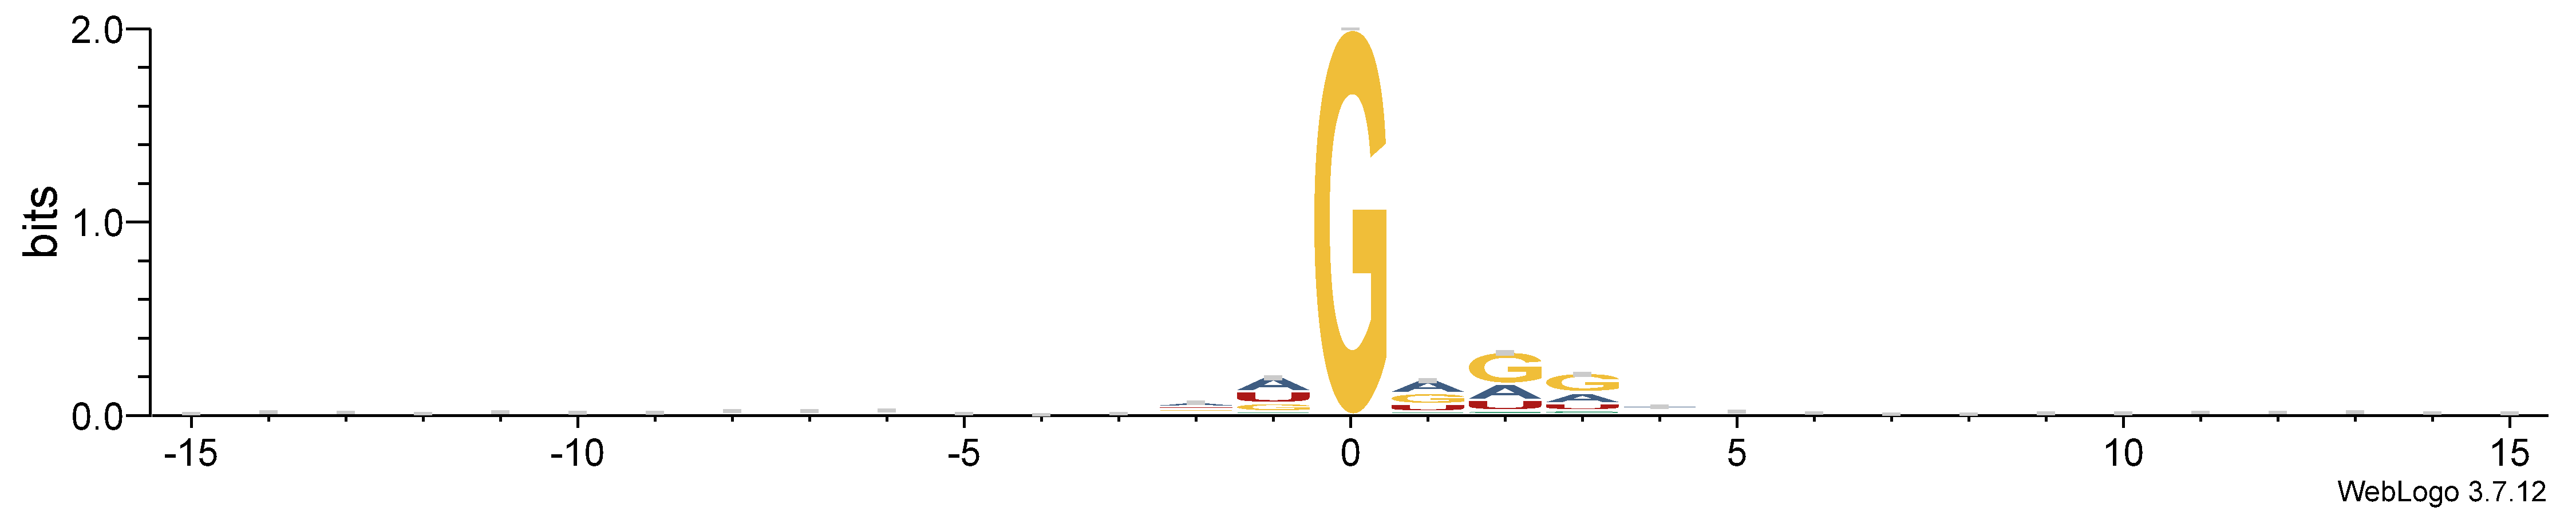
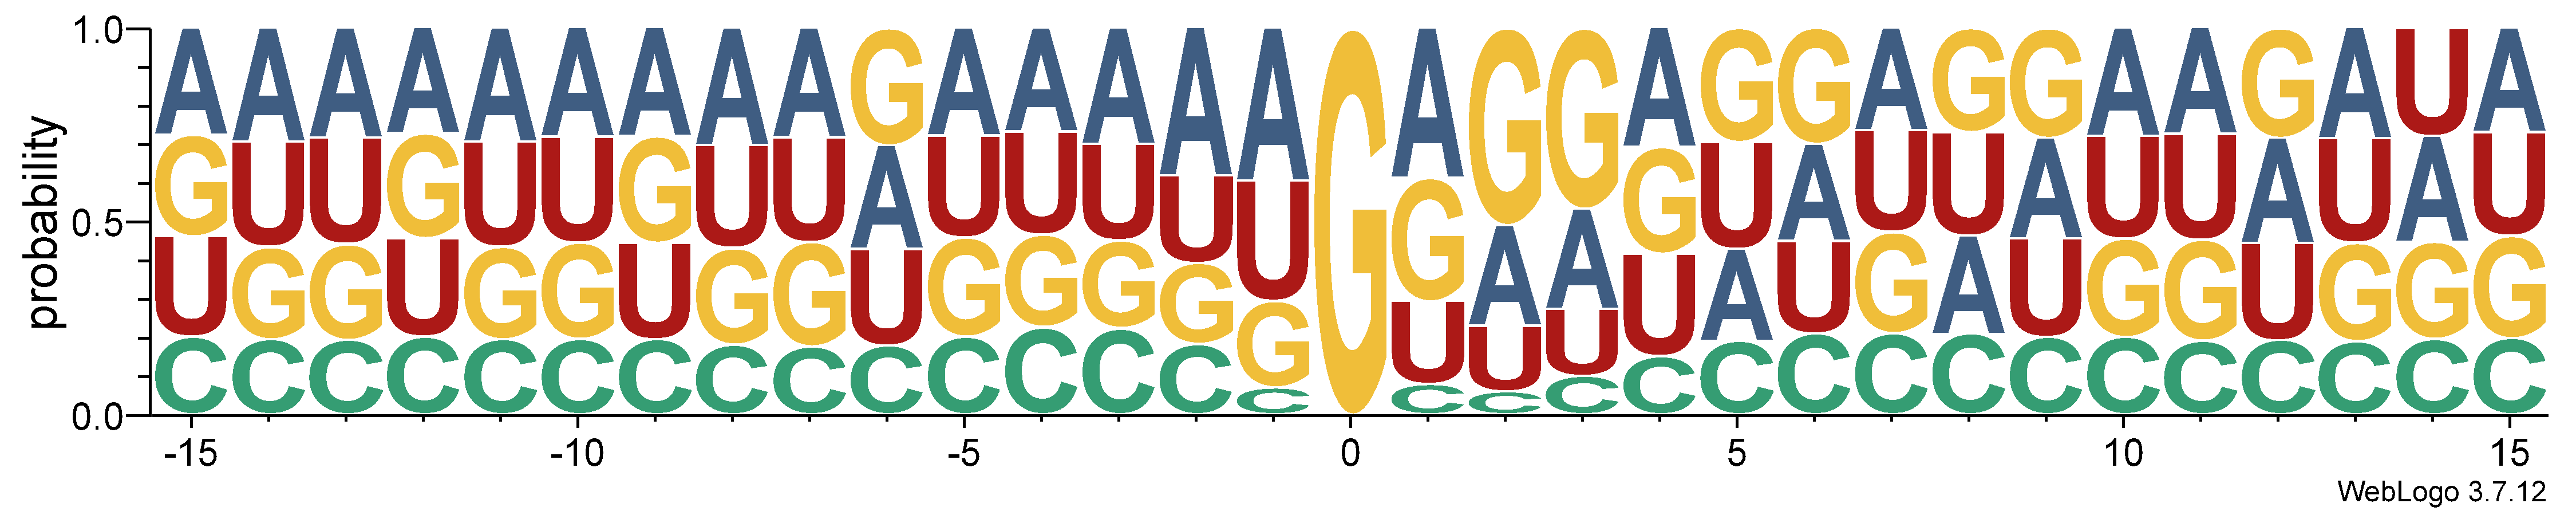